In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [2]:
sns.set(style='white', context='notebook', palette='deep')


In [3]:
# Load the data
train = pd.read_csv(r"C:\Users\haider computer s\Fiver\project-Classification\Datasets\Mnist\mnist_train.csv")
test = pd.read_csv(r"C:\Users\haider computer s\Fiver\project-Classification\Datasets\Mnist\mnist_test.csv")

In [4]:
Y_test = test["label"]

# Drop 'label' column
X_test = test.drop(labels = ["label"],axis = 1) 

# free some space
del test 

g = sns.countplot(Y_test)

Y_test.value_counts()

C:\Users\haider computer s\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: label, dtype: int64

In [5]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

C:\Users\haider computer s\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: label, dtype: int64

In [6]:
# Check the data
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
X_test.isnull().any().describe()


count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [9]:
X_train.shape

(60000, 784)

In [10]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [11]:
# Set the random seed
random_seed = 2

In [12]:
# Split the train and the validation set for the fitting
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state=random_seed)

In [13]:
w, h = 28, 28
x_train = x_train.values.reshape(x_train.shape[0],w,h,1)

In [14]:
x_train.shape

(48000, 28, 28, 1)

In [15]:
x_val = x_val.values.reshape(x_val.shape[0],w,h,1)

In [16]:
# Some examples
g = plt.imshow(x_train[1])

In [17]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
from keras import regularizers
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(500,kernel_regularizer=regularizers.l1(0.01),activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [19]:
optimizer = tf.keras.optimizers.Adam(lr=0.001, epsilon=1e-08, decay=0.0)
import keras.backend as K
import tensorflow as tf
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def conditional_average_metric(y_true, y_pred):
    spec = specificity(y_true, y_pred)
    sens = sensitivity(y_true, y_pred)

    minimum = K.minimum(spec, sens)
    condition = K.less(minimum, 0.5)

    multiplier = 0.001
    # This is the constant used to substantially lower
    # the final value of the metric and it can be set to any value
    # but it is recommended to be much lower than 0.5

    result_greater = 0.5 * (spec + sens)
    result_lower = multiplier * (spec + sens)
    result = K.switch(condition, result_lower, result_greater)

    return result
def sensitivity(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
metrics=[tf.keras.metrics.AUC(num_thresholds=200,curve='ROC',summation_method='interpolation',name=None,dtype=None,thresholds=None,multi_label=False,num_labels=None,label_weights=None,from_logits=False),
                         tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy',
                   specificity,conditional_average_metric ,sensitivity,F1_Score]

In [20]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=metrics)

In [22]:
# EarlyStopping
from keras.callbacks import ModelCheckpoint,EarlyStopping
early_stop = EarlyStopping(monitor='val_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

#ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best_CNN.hdf5',
                                  save_best_only=True,
                                  verbose=1)

In [23]:

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

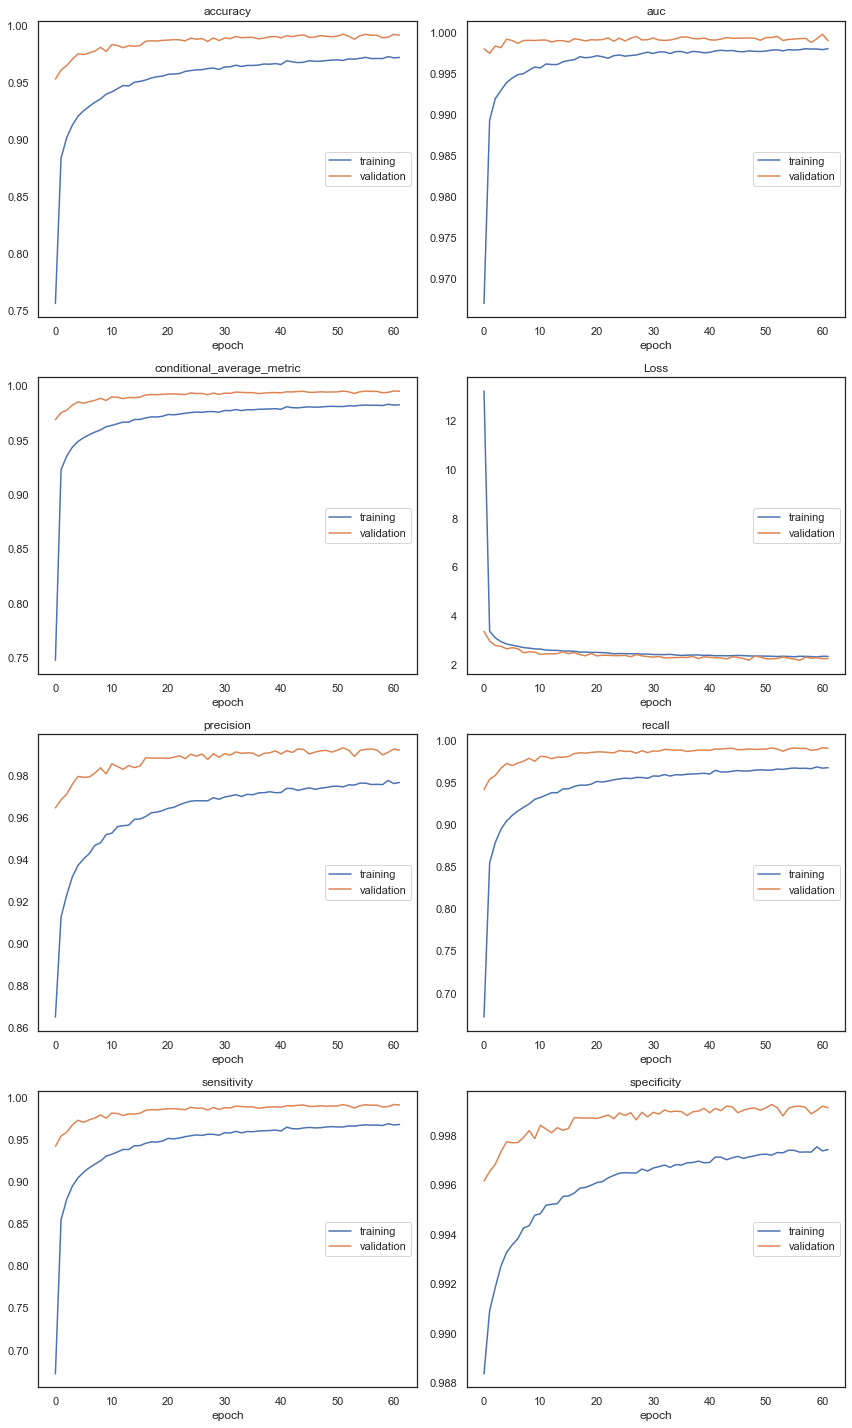

accuracy
	training         	 (min:    0.756, max:    0.973, cur:    0.972)
	validation       	 (min:    0.953, max:    0.992, cur:    0.991)
auc
	training         	 (min:    0.967, max:    0.998, cur:    0.998)
	validation       	 (min:    0.997, max:    1.000, cur:    0.999)
conditional_average_metric
	training         	 (min:    0.748, max:    0.983, cur:    0.983)
	validation       	 (min:    0.969, max:    0.995, cur:    0.995)
Loss
	training         	 (min:    2.306, max:   13.214, cur:    2.330)
	validation       	 (min:    2.170, max:    3.357, cur:    2.240)
precision
	training         	 (min:    0.865, max:    0.978, cur:    0.977)
	validation       	 (min:    0.965, max:    0.993, cur:    0.992)
recall
	training         	 (min:    0.671, max:    0.969, cur:    0.968)
	validation       	 (min:    0.942, max:    0.992, cur:    0.991)
sensitivity
	training         	 (min:    0.672, max:    0.969, cur:    0.968)
	validation       	 (min:    0.942, max:    0.992, cur:    0.991)
sp

In [24]:
# Fit the model
batch_size = 89
epochs = 100
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_val,y_val),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[early_stop,plot_loss_1,tl_checkpoint_1])

In [26]:
model.load_weights('tl_model_v1.weights.best_CNN.hdf5') # initialize the best trained weights


In [29]:
X_test = X_test.values.reshape(X_test.shape[0],w,h,1)

In [30]:
y_pred = model.predict(X_test)

In [34]:
Y_test = to_categorical(Y_test, num_classes = 10)

In [35]:
Digitss_mnist_labels = [0,  # index 0
                        1,      # index 1
                        2,     # index 2 
                        3,        # index 3 
                        4,         # index 4
                        5,       # index 5
                        6,        # index 6 
                        7,      # index 7 
                        8,          # index 8 
                        9]   # index 9

In [37]:
score = model.evaluate(X_test,Y_test,verbose=0)
print('\n', 'Accuracy:', score[1])


 Accuracy: 0.999334990978241


In [38]:
Y_test=np.argmax(Y_test,axis=1)

In [39]:
y_pred=np.argmax(y_pred, axis=1)

<AxesSubplot:>

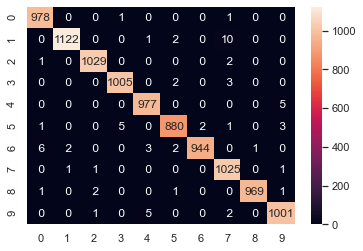

In [41]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(Y_test,y_pred),annot=True,fmt='2.0f')

In [ ]:
#F1 Score is ration of 0.99# you just have to run it for reults

## Testing

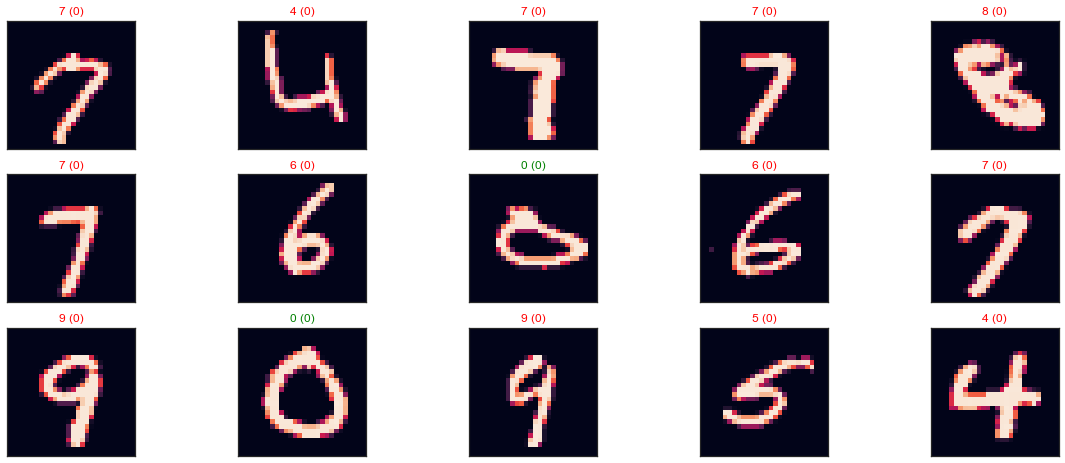

In [43]:
y_hat = model.predict(X_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(Y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(Digitss_mnist_labels[predict_index], 
                                  Digitss_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))